# Evapotranspiración MODIS
_Autor:_    __Jesús Casado__ <br> _Revisión:_ __21/01/2020__ <br>

__Introducción__<br>
Datos de MODIS sobre evapotranspiración en la cuenca del Deva. 
1. Se cargan los datos originales (8 días) y se agregan a diversas frecuencias temporales (mensual y anual). Los datos se muestran en mapas y series.
2. Introducción al análisis de EOFs sobre los datos anteriores.

__Cosas que arreglar__ <br>
Cómo leer atributos del archivo _hdf_ de MODIS.

***

__Índice__ <br>
__[Datos](#Datos)__<br>
[DEM de la cuenca](#DEM-de-la-cuenca-(ETRS89-UTM30N))<br>
[Evapotranspiración MODIS](#Evapotranspiración-MODIS)<br>

__[Análisis](#Análisis)__<br>
[8 diario](#8-diario)<br>
[Mensual](#Mensual)<br>
[Anual](#Anual)<br>
[EOF](#EOF)<br>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.style.use('dark_background')
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.gridspec import GridSpec
from netCDF4 import Dataset, num2date, date2num
#import h5py
from datetime import datetime
from calendar import monthrange
import time

import os
rutaBase = os.getcwd().replace('\\', '/') + '/'

import geopandas as gpd
import earthpy as et

from eofs.standard import Eof

import matplotlib.animation as animation
from IPython.display import HTML

In [2]:
from pyproj import Proj, transform, CRS
os.environ['PROJ_LIB'] = r'C:\Anaconda3\pkgs\proj4-4.9.3-vc14_5\Library\share'

In [3]:
os.chdir(rutaBase + '../src/')
from funciones_MODIS import *
from funciones_EOF import *

***
## Datos
### DEM de la cuenca (ETRS89-UTM30N)

In [4]:
# cargar shapefile
rutaCarto = 'F:/OneDrive - Universidad de Cantabria/Cartografia/Politico/Espana/'
ESP = gpd.read_file(rutaCarto + 'Provincias_ETRS89_30N.shp')

# # gráfico
# fig, ax = plt.subplots(figsize=(6, 6))
# ESP.geometry.boundary.plot(ax=ax, edgecolor='grey', lw=.5);
# # tipo de datos
# type(ESP)
# # extensión espacial
# ESP.total_bounds
# # sistema de coordenadas
# ESP.crs
# # tipo de geometría
# ESP.geom_type.head()

In [5]:
# cargar DEM de la cuenca alta del Deva
dem = ascii2df('../data/dem.asc')
XXdem = dem.columns
YYdem = dem.index

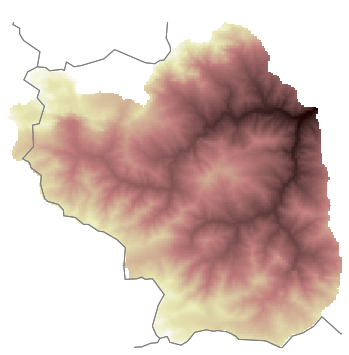

In [6]:
fig, ax = plt.subplots(figsize=(6, 6))
ESP.geometry.boundary.plot(ax=ax, edgecolor='gray', lw=1)
ax.imshow(dem, cmap='pink', extent=[XXdem[0], XXdem[-1], YYdem[-1], YYdem[0]])
ax.set(xlim=(XXdem[0], XXdem[-1]), ylim=(YYdem[-1], YYdem[0]))
# ax.axis('equal');
ax.set_title('DEM cuenca del DEVA-1265', fontsize=13, fontweight='bold')
ax.axis('off');

### Datos MODIS

In [7]:
# rutas de entrada y salida
rutaMODIS = 'F:/OneDrive - Universidad de Cantabria/Cartografia/MODIS/'
# rutaExport = 'F:/Proyectos/GESDIVAH/SDM/Data/PdE/MODIS/'
rutaExport = rutaBase + '../output/ET/'
if os.path.exists(rutaExport) == False:
    os.makedirs(rutaExport)

In [8]:
# parámetros de la extracción de datos de MODIS
products = {'Terra': 'MOD16A2', 'Aqua': 'MYD16A2'}
var = 'ET_500m'
dateslim = None
tiles = ['h17v04']
clip = rutaBase + '../data/dem.asc'
coordsOut = 'epsg:25830'
filename = 'MODIS_' + var + '.nc'

In [9]:
if filename not in os.listdir(rutaExport):
    
    ##########################
    ### CARGAR DATOS BRUTOS###
    ##########################
    
    ET = {sat: {} for sat in products}
    for sat in products:
        print(sat)
        product = products[sat]
        MODIS_extract(rutaMODIS, product, var, tiles, dateslim=dateslim, clip=clip,
                      coordsClip=coordsOut, verbose=True)

        # extraer datos, coordenadas y fechas
        ET[sat]['ET'] = MODIS_extract.data
        ET[sat]['XX'] = MODIS_extract.Xcoords
        ET[sat]['YY'] = MODIS_extract.Ycoords
        ET[sat]['dates'] = MODIS_extract.dates
        
        print()

    ######################
    ### EXPORTAR DATOS ###
    ######################
    
    # definir el netcdf
    ncMODIS = Dataset(rutaExport + filename, 'w', format='NETCDF4')

    # crear grupos
    terra = ncMODIS.createGroup('Terra')
    aqua = ncMODIS.createGroup('Aqua')

    # crear atributos
    ncMODIS.description = 'Serie temporal de mapas de ET de la cuenca del Deva obtenidos a partir de MODIS'
    ncMODIS.history = 'Creado el ' + datetime.now().date().strftime('%Y-%m-%d')
    ncMODIS.source = 'https://e4ftl01.cr.usgs.gov/'
    ncMODIS.coordinateSystem = 'epsg:25830' # 'SINUSOIDAL'

    for group, sat, product in zip([terra, aqua], ['Terra', 'Aqua'], ['MOD16A2', 'MYD16A2']):
        # crear las dimensiones
        time = group.createDimension('time', len(ET[sat]['dates']))
        Y = group.createDimension('Y', ET[sat]['YY'].shape[0])
        X = group.createDimension('X', ET[sat]['YY'].shape[1])

        # crear variables
        et = group.createVariable(product, 'f4', ('time', 'Y', 'X'))
        et.units = 'm^2/m^2'
        times = group.createVariable('time', 'f8', ('time',))
        times.units = 'días desde el 0001-01-01'
        times.calendar = 'Gregoriano'
        Xs = group.createVariable('X', 'u4', ('X',))
        Xs.units = 'm'
        Ys = group.createVariable('Y', 'u4', ('Y',))
        Ys.units = 'm'

        # variable ET
#         for ki in range(ET[sat]['ET'].shape[2]):
#             et[ki,:,:] = ET[sat]['ET'][:,:,ki]
        et[:,:,:] = ET[sat]['ET'][:,:,:]
        # variable 'time'
        deltas = [date - datetime(1, 1, 1).date() for date in ET[sat]['dates']]
        times[:] = [delta.days for delta in deltas]
        # variable 'X'
        x = ET[sat]['XX'].mean(axis=0)
        pos = int(len(x) / 2)
        cellsize = np.mean(x[1:] - x[:-1])
        Xs[:] = [x[pos] + (i - pos) * cellsize for i in range(len(x))]
        # variable 'Y'
        y = ET[sat]['YY'].mean(axis=1)
        pos = int(len(y) / 2)
        cellsize = np.mean(y[1:] - y[:-1])
        Ys[:] = [y[pos] + (i - pos) * cellsize for i in range(len(y))]

    ncMODIS.close()

Terra
Seleccionar archivos
nº de archivos (fechas): 863

Generar atributos globales
dimensión:		(2400, 2400)
esquina inf. izqda.:	(-1111950.52, 4447802.08)
esquina sup. dcha.:	(      0.00, 5559752.60)

Crear máscaras
dimensión:		(  48,   49)
esquina inf. izqda.:	( 348660.82, 4764015.80)
esquina sup. dcha.:	( 370177.84, 4785338.63)

Importar datos
Fecha 863 de 863: 2019-11-01	||	Tile  1 de  1: h17v04

Aqua
Seleccionar archivos
nº de archivos (fechas): 797

Generar atributos globales
dimensión:		(2400, 2400)
esquina inf. izqda.:	(-1111950.52, 4447802.08)
esquina sup. dcha.:	(      0.00, 5559752.60)

Crear máscaras
dimensión:		(  48,   49)
esquina inf. izqda.:	( 348660.82, 4764015.80)
esquina sup. dcha.:	( 370177.84, 4785338.63)

Importar datos
Fecha 797 de 797: 2019-11-01	||	Tile  1 de  1: h17v04



In [10]:
###############################
### IMPORTAR DATOS TRATADOS ###
###############################

# Cargar netcdf con los datos MODIS
ncRead = Dataset(rutaExport + filename, 'r', format='NETCDF4')

# extraer datos en un diccionario
ET = {'Terra': {}, 'Aqua': {}}
for sat, product in zip(['Terra', 'Aqua'], ['MOD16A2', 'MYD16A2']):
    # evapotranspiración
    ET[sat]['ET'] = ncRead[sat][product][::]
    # fechas
    ET[sat]['dates'] = [datetime(1, 1, 1) + timedelta(time) for time in ncRead[sat]['time'][:]]
    # coordenadas
    ET[sat]['X'] = ncRead[sat]['X'][:]
    ET[sat]['Y'] = ncRead[sat]['Y'][:]

ncRead.close()

## Análisis
### 8 diario

C:\Anaconda3\envs\test\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
F:\Codigo\GitHub\MODIS\src\funciones_MODIS.py:515: RuntimeWarning: Mean of empty slice
  ax.plot(timex, np.nanmean(datax, axis=(1, 2)), c=colors[c][1], lw=4*lw)


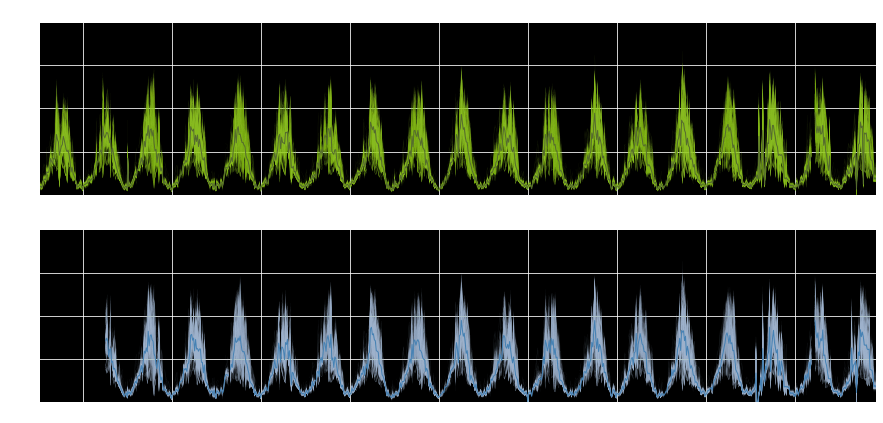

In [11]:
plotMODISseries(ET, 'ET', 'dates', r=20, ylabel='ET acumulada 8 días (mm)')
# plt.savefig(rutaExport + 'ET serie 8 días.png', dpi=300, tight_layout=True)

In [ ]:
def animate3Darray(data, dates, minmax, cblabel='', fps=2, dpi=100, pathfile=None):
    """
    """
    
    # definir configuración del gráfico en blanco
    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(np.zeros(data.shape[1:]), animated=True,
                   cmap='summer_r', vmin=minmax[0], vmax=minmax[1])
    plt.axis('off')
    cb = plt.colorbar(im, shrink=.7)
    cb.set_label(cblabel, fontsize=12)
    title = ax.text(.5, 1.05, '', fontsize=13, fontweight='bold',
                    transform=ax.transAxes, horizontalalignment='center')

    def updatefig(i, *args):
        """Función que define los zdatos a mostrar  el título en cada iteración"""
        title.set_text(dates[i].date())
        im.set_array(data[i,:,:])
        return im,

    # genera la animación iterando sobre 'updatefig' un número 'frames' de veces
    ani = animation.FuncAnimation(fig, updatefig, frames=data.shape[0], interval=1000/fps,
                                  blit=True)
    # guardar vídeo
    if pathfile is not None:
        ani.save(pathfile, fps=fps, extra_args=['-vcodec', 'libx264'], dpi=dpi)
    # plt.show()

    # ver vídeo en el 'notebook'
    return HTML(ani.to_html5_video())

In [ ]:
# video of Terra's 8-daily data
animate3Darray(ET['Terra']['ET'], ET['Terra']['dates'], minmax=[0, 60],
               cblabel='ET 8 días (mm)', fps=8, pathfile=rutaExport + 'ETdeva_MODIS-Terra.mp4')

In [ ]:
# video of Aqua's 8-daily data
animate3Darray(ET['Aqua']['ET'], ET['Aqua']['dates'], minmax=[0, 60],
               cblabel='ET 8 días (mm)', fps=8, pathfile=rutaExport + 'ETdeva_MODIS-Aqua.mp4')

### Mensual
__Medias mensuales__

In [ ]:
def mediaMensual(dates, ET):
    """
    """
    
    # medias mensuales
    meanMET = np.zeros((12, ET.shape[1], ET.shape[2])) * np.nan
    for m, month in enumerate(range(1, 13)):
        ks = [k for k, date in enumerate(dates) if date.month == month]
        meanMET[m,:,:] = np.nanmean(ET[ks,:,:], axis=0)
        
    return meanMET

In [ ]:
# generar medias mensuales de ET
for sat in ET.keys():
    ET[sat]['meanMET'] = mediaMensual(ET[sat]['dates'], ET[sat]['ET'])

In [ ]:
ncols = 6
nrows = int(np.ceil(12 / ncols)) * 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2.75*ncols, 2.75*nrows))
fig.subplots_adjust(right=0.9)

r = 10
vmin = np.floor(min([np.nanmin(ET[sat]['meanMET']) for sat in ET.keys()]) / r) * r
vmax = np.ceil(max([np.nanmax(ET[sat]['meanMET']) for sat in ET.keys()]) / r) * r
cmaps = ['summer_r', 'Blues']

for s, (sat, cmap) in enumerate(zip(ET.keys(), cmaps)):
    for k, month in enumerate(range(1, 13)):
        f, c = int(k / ncols) + s * 2, k % ncols
        im = ax[f,c].imshow(ET[sat]['meanMET'][k,:,:], cmap=cmap, vmin=vmin, vmax=vmax)
        ax[f,c].set_title(datetime(1900, month, 1).strftime('%b'), fontsize=13)
        ax[f,c].axis('off')
    
    cbar_ax = fig.add_axes([0.925, 0.6 - 0.4 * s, 0.01, 0.2])
    cbar_ax.tick_params(labelsize=12)
    cb = plt.colorbar(im, cax=cbar_ax, orientation='vertical')
    cb.set_label('mm/mes', fontsize=14)
    fig.text(0.1, 0.7  - 0.4 * s, sat, fontsize=14, fontweight='bold', rotation=90,
             verticalalignment='center')
fig.text(0.5, .92, 'ET mensual', fontsize=15, fontweight='bold', horizontalalignment='center');
plt.savefig(rutaExport + 'ET medias mensuales.png', dpi=300, tight_layout=True)

In [ ]:
# mostrar la media mensual para cada celda y la media de la cuenca
fig, axes = plt.subplots(ncols=2, figsize=(15, 3.5), sharey=True)

r = 10
ymax = np.ceil(max([np.nanmax(ET[sat]['meanMET']) for sat in ET.keys()]) / r) * r
colors = [['yellowgreen', 'darkolivegreen'], ['lightsteelblue', 'steelblue']]

for c, (ax, sat) in enumerate(zip(axes, ET.keys())):
    meanMETx = ET[sat]['meanMET']
    for i in range(meanMETx.shape[1]):
        for j in range(meanMETx.shape[2]):
            if np.isnan(meanMETx[:,i,j]).sum() == meanMETx.shape[0]: # celda vacía
                continue
            else:
                ax.plot(meanMETx[:,i,j], lw=.25, c=colors[c][0], alpha=.25)
    ax.plot(np.nanmean(meanMETx, axis=(1, 2)), c=colors[c][1], lw=1.2)
    ax.tick_params(labelsize=11)
    ax.set(xlim=(0, 11), ylim=(0, ymax))
    if c == 0:
        ax.set_ylabel('ET mensual (mm)', fontsize=13);
    monthnames = [datetime(1900, m, 1).strftime('%b') for m in range(1, 13)]
    ax.set_xticklabels(monthnames[::2])
    ax.set_title(sat, fontsize=13, fontweight='bold')
plt.savefig(rutaExport + 'ET serie medias mensuales.png', dpi=300, tight_layout=True)

#### Serie mensual

In [ ]:
def serieMensual(dates, ET):
    """
    """
    
    start = datetime(dates[0].year, dates[0].month, 1).date()
    end = dates[-1] + timedelta(8)
    end = datetime(end.year, end.month, monthrange(end.year, end.month)[1]).date()
    days = pd.date_range(start, end)
    months = pd.date_range(start, end, freq='M')
    len(days), len(months)

    # serie mensuales
    serieMET = np.zeros((len(months), ET.shape[1], ET.shape[2])) * np.nan
    for i in range(ET.shape[1]):
        for j in range(ET.shape[2]):
            print('celda {0:>5} de {1:>5}'.format(i * ET.shape[2] + j + 1,
                                                  ET.shape[1] * ET.shape[2]), end='\r')
            if np.isnan(ET[:,i,j]).sum() == ET.shape[0]: # ningún dato en toda la serie
                continue
            else:
                # generar serie diaria
                auxd = pd.Series(index=days)
                for k, (st, et) in enumerate(zip(dates, ET[:,i,j])):
                    if np.isnan(et):
                        continue
                    else:
                        if st != dates[-1]:
                            en = dates[k+1]
                        else:
                            en = st + timedelta(8)
                        auxd[st:en - timedelta(1)] = et / (en - st).days
                # generar serie mensual
                auxm = auxd.groupby([auxd.index.year, auxd.index.month]).agg(np.nanmean)
                auxm.index = [datetime(idx[0], idx[1], monthrange(idx[0], idx[1])[1]).date() for idx in auxm.index]
                # asignar serie mensual a su celda en el array 3D
                serieMET[:,i,j] = auxm.iloc[:serieMET.shape[0]].copy()
                del auxd, auxm
    return serieMET, months

In [ ]:
# generar series de ET mensual
for sat in ET.keys():
    ET[sat]['serieMET'], ET[sat]['months'] = serieMensual(ET[sat]['dates'], ET[sat]['ET'])

In [ ]:
plotMODISseries(ET, 'serieMET', 'months', r=2, ylabel='ET mensual (mm/d)')
plt.savefig(rutaExport + 'ET serie mensual.png', dpi=300, tight_layout=True)

In [ ]:
# video of monthly-aggregated Terra's data
animate3Darray(ET['Terra']['serieMET'], ET['Terra']['months'], minmax=[0, 10],
               cblabel='ET (mm)', fps=2, dpi=200,
               pathfile=rutaExport + 'ETdeva_MODIS-Terra.mp4')

In [ ]:
animate3Darray(ET['Aqua']['serieMET'], ET['Aqua']['months'], minmax=[0, 10],
               cblabel='ET (mm)', fps=2, dpi=200,
               pathfile=rutaExport + 'ETdeva_MODIS-Aqua.mp4')

### Anual
__Media anual__

In [ ]:
for sat in ET.keys():
    ET[sat]['meanAET'] = np.nanmean(ET[sat]['ET'], axis=0) * 365 / 8

In [ ]:
# mapa de ET media anual
fig, axes = plt.subplots(ncols=2, figsize=(8, 4))

r = 100
vmin = np.floor(min([np.nanmin(ET[sat]['meanAET']) for sat in ET.keys()]) / r) * r
vmax = np.ceil(max([np.nanmax(ET[sat]['meanAET']) for sat in ET.keys()]) / r) * r

cmaps = ['summer_r', 'Blues']

for c, (ax, sat) in enumerate(zip(axes, ET.keys())):
    im = ax.imshow(ET[sat]['meanAET'], cmap=cmaps[c], vmin=vmin, vmax=vmax)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    ax.set_title(sat, fontsize=13, fontweight='bold')
    ax.axis('off');
plt.savefig(rutaExport + 'ET mapa media anual.png', dpi=300, tight_layout=True)

__Serie anual__

In [ ]:
def serieAnual(dates, ET):
    
    # años con datos suficientes
    years = np.unique(np.array([date.year for date in dates]))
    ksyear = {}
    for year in years:
        ks = [k for k, date in enumerate(dates) if date.year == year]
        if len(ks) < 40: # si faltan más de 5 mapas en un año 
            years = years[years != year]
            continue
        else:
            ksyear[year] = ks

    # medias anuales        
    serieAET = np.zeros((len(years), ET.shape[1], ET.shape[2])) * np.nan
    for y, year in enumerate(years):
        serieAET[y,:,:] = np.nanmean(ET[ksyear[year],:,:], axis=0) * 365 / 8
        
    return serieAET, years

In [ ]:
# generar series de ET anual
for sat in ET.keys():
    ET[sat]['serieAET'], ET[sat]['years'] = serieAnual(ET[sat]['dates'], ET[sat]['ET'])

In [ ]:
plotMODISseries(ET, 'serieAET', 'years', r=100, ylabel='ET anual (mm)', lw=.25, alpha=.25)
plt.savefig(rutaExport + 'ET serie anual.png', dpi=300, tight_layout=True)

In [ ]:
ymin = min([np.min(ET[sat]['years']) for sat in ET.keys()])
ymax = max([np.max(ET[sat]['years']) for sat in ET.keys()])
years = np.arange(ymin, ymax + 1)

ncols = 6
nrows = int(np.ceil(len(years) / ncols)) * 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2.75*ncols, 2.75*nrows))
fig.subplots_adjust(bottom=0.1)

r = 100
vmin = np.floor(min([np.nanmin(ET[sat]['serieAET']) for sat in ET.keys()]) / r) * r
vmax = np.ceil(max([np.nanmax(ET[sat]['serieAET']) for sat in ET.keys()]) / r) * r
cmaps = ['summer_r', 'Blues']

for s, (sat, cmap) in enumerate(zip(ET.keys(), cmaps)):
    for y, year in enumerate(years):
        f, c = int(y / ncols + s * (nrows / 2)), y % ncols
        if year in ET[sat]['years']:
            k = np.where(year == ET[sat]['years'])[0][0]
            im = ax[f,c].imshow(ET[sat]['serieAET'][k,:,:], cmap=cmap, vmin=vmin, vmax=vmax)
            ax[f,c].set_title(year, fontsize=13)
            ax[f,c].axis('off')
        else:
            ax[f,c].axis('off')
    
    cbar_ax = fig.add_axes([0.92, 0.6  - .4 * s, 0.01, 0.2])
    cbar_ax.tick_params(labelsize=12)
    cb = plt.colorbar(im, cax=cbar_ax, orientation='vertical')
    cb.set_label('mm/año', fontsize=13)
    fig.text(.1, .7 - .4 * s, sat, fontsize=14, fontweight='bold', rotation=90,
             verticalalignment='center')
fig.text(.5, .92, 'ET anual', fontsize=15, fontweight='bold',
         horizontalalignment='center');
plt.savefig(rutaExport + 'ET mapas anuales.png', dpi=300, tight_layout=True)

## EOF
### Terra

In [ ]:
eofMODIS(ET['Terra']['serieAET'], ET['Terra']['Y'], nmodes=4, coordsIn='epsg:25830',
         lons=ET['Terra']['X'], plot='corr')

eofs = eofMODIS.eofs
pcs = eofMODIS.pcs
corr = eofMODIS.correlation
var = eofMODIS.explainedVariance
plt.savefig(rutaExport + 'ET eofs-Terra anual.png', dpi=300, tight_layout=True)

### Aqua

In [ ]:
eofMODIS(ET['Aqua']['serieAET'], ET['Aqua']['Y'], nmodes=4, coordsIn='epsg:25830',
         lons=ET['Aqua']['X'], plot='corr')

eofs = eofMODIS.eofs
pcs = eofMODIS.pcs
corr = eofMODIS.correlation
var = eofMODIS.explainedVariance
plt.savefig(rutaExport + 'ET eofs-Aqua anual.png', dpi=300, tight_layout=True)

<font color='indianred'>__¡Hay que completar los datos!__ El paquete `eof` elimina las celdas en las que hay algún NaN.

In [ ]:
# At · A = Lambda
AtA = np.matrix(pcs) * np.matrix(np.transpose(pcs))
Lambda = np.diag(lambdas)

In [ ]:
reconstructed_data = solver.reconstructedField(4)
pseudo_pcs = solver.projectField(other_field)

In [ ]:
# 'SOLVERS' multivariable
from eofs.multivariate.standard import MultivariateEof
msolver = MultivariateEof([data1, data2, data3])
eofs_data1, eofs_data2, eofs_data3 = msolver.eofs()
pcs = msolver.pcs()

### EOF

In [ ]:
data[0,:,:].flatten()

In [ ]:
# matriz F: filas, pasos temporales; columnas, puntos en el espacio
F = data.reshape((data.shape[0], data.shape[1] * data.shape[2]))
F.shape

In [ ]:
# # eliminar filas sin ningún dato
# F = F[np.nansum(np.isnan(F), axis=1) == 0]

In [ ]:
# eliminar la media de cada columna
F_ = F - np.nanmean(F, axis=0)

In [ ]:
# matriz de covarianza
np.transpose(F)

In [ ]:
plt.imshow(np.cov(F_))

In [ ]:
# calcular anomalías 
anomETx = ETx - meanAETx
plt.imshow(np.nanmin(anomETx, axis=0), cmap='coolwarm');

In [ ]:
# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.
coslat = np.cos(np.deg2rad(lats)).clip(0., 1.)
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(z_djf, weights=wgts)

In [ ]:
import iris
from eofs.iris import Eof

In [ ]:
# # read a spatial-temporal field, time must be the first dimension
sst = iris.load_cube(test)
# sst

In [ ]:
# create a solver class, taking advantage of built-in weighting
solver = Eof(test, weights='coslat')

##### Toda la hoja MODIS

In [ ]:
# Mapas de ET de la cuenca del Deva
MODIS_maps(rutaMODIS, files, var='ET_500m', coordsOut='epsg:25830')
data = MODIS_maps.data
XX, YY = MODIS_maps.Xcoords, MODIS_maps.Ycoords

print('filas: {0:>3}\tcolumnas: {1:>3}\tfechas: {2:>3}'.format(*data.shape))

In [ ]:
# ET media en el periodo
datamean = np.nanmean(data, axis=2)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

# provincias
ESP.geometry.boundary.plot(ax=ax, edgecolor='k', lw=.8, zorder=3)
# ET
ETmap = ax.scatter(XX, YY, marker='s', c=datamean, cmap='summer_r', s=1, zorder=1)
cb = plt.colorbar(ETmap, shrink=.5)
cb.set_label('mm', fontsize=12)


# configuración
ax.set(xlim=(-20000, 600000), ylim=(4500000, 4900000))
ax.set_title('ET media', fontsize=13, fontweight='bold');
ax.set_axis_off();

##### Cuenca del Deva

In [ ]:
# Mapas de ET de la cuenca del Deva
MODIS_maps(rutaMODIS, files, var='ET_500m', coordsOut='epsg:25830', basin=dem)
datab = MODIS_maps.data
XXb, YYb, datesb = MODIS_maps.Xcoords, MODIS_maps.Ycoords, MODIS_maps.dates

print('filas: {0:>3}\tcolumnas: {1:>3}\tfechas: {2:>3}'.format(*datab.shape))

In [ ]:
# años con datos
years = np.unique(np.array([date.year for date in datesb]))
years

In [ ]:
# medias anuales
databyear = np.zeros((datab.shape[0], datab.shape[1], len(years))) * np.nan
for y, year in enumerate(years):
    ks = [k for k, date in enumerate(datesb) if date.year == year]
    if len(ks) < 40:
        years.remove(year)
        continue
    else:
        print(year)
        databyear[:,:,y] = np.nanmean(datab[:,:,ks], axis=2)

In [ ]:
if 'databyear' in locals():
    np.dstack((databyear, np.nanmean(datab[:,:,ks], axis=2)))
else:
    databyear = np.nanmean(datab[:,:,ks], axis=2)

In [ ]:
tyear = 2002

In [ ]:
# ET amedia en el periodo
databmean = np.nanmean(datab, axis=2)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

# provincias
ESP.geometry.boundary.plot(ax=ax, edgecolor='k', lw=1, ls='--', zorder=2)
# ET
ETmap = ax.scatter(ET['Terra']['XX'], ET['Terra']['YY'], marker='s', c=ET['Terra']['meanAET'],
                   cmap='YlGn', s=20, zorder=2)
cb = plt.colorbar(ETmap, shrink=.5)
cb.set_label('mm', fontsize=12)
# mdt
ax.imshow(dem, cmap='pink', extent=[XXdem[0], XXdem[-1], YYdem[-1], YYdem[0]], zorder=1)

# configuración
ax.set_title('ET media', fontsize=13, fontweight='bold')
ax.axis('off');

In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(dem, cmap='pink', extent=[XXdem[0], XXdem[-1], YYdem[-1], YYdem[0]], zorder=1)
plt.imshow(ET['Terra']['meanAET'], extent=[XXa[0,0], XXa[-1,-1], YYa[-1,-1], YYa[0,0]])

In [ ]:
[XXa[0,0], XXa[-1,-1], YYa[-1,-1], YYa[0,0]]